In [ ]:
from google.colab import drive

In [ ]:
#drive.mount('/content/drive')

In [ ]:
import regex as re
import nltk
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
import numpy as np
from sklearn.metrics import mean_squared_error as MSE, r2_score
from scipy.stats import skew,kurtosis,zscore
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Flight_Ticket_Participant_Datasets/Data_Train.xlsx")
df.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [ ]:
df.Total_Stops.value_counts()


1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [ ]:
df.Price.skew()

1.8125523782189141

In [ ]:
def distribution_check(df,Cols):
    plt.figure(figsize=(12,7))
    fig = 1
    i = (len(Cols)//3)+1
    for col in Cols:
        sk = " Skewness : " + str(skew(df[col])) +"\nKurtosis :" + str(kurtosis(df[col]))
        plt.subplot(i, 3, fig)
        sns.distplot(df[col]).set_title(sk)
        fig = fig+1

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


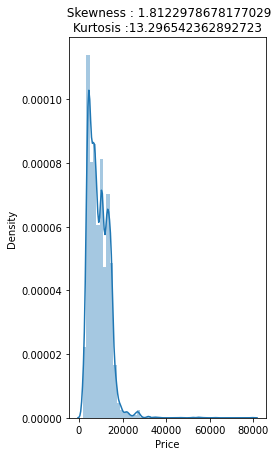

In [ ]:
distribution_check(df,['Price'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


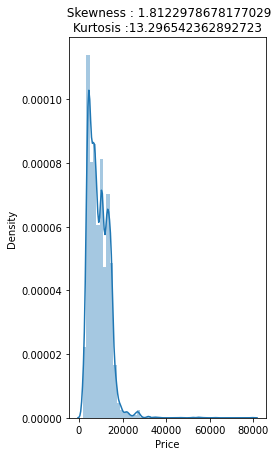

In [ ]:
distribution_check(df,['Price'])

In [ ]:
df['Price'] = np.log(df['Price'])
y = df['Price']
df.Price.skew()

-0.2547370678380174

## Feature Engineering

In [ ]:
from datetime import timedelta
df['Day_of_Booking'] = '1/3/2019'
df['Day_of_Booking'] = pd.to_datetime(df['Day_of_Booking'],format='%d/%m/%Y')
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y')
df['Days_to_Departure'] = (df['Date_of_Journey'] - df['Day_of_Booking']).dt.days
df['Days_to_Departure'] = df['Days_to_Departure']

In [ ]:

df['Date_of_Journey'] = pd.to_datetime(df.Date_of_Journey)
df['weekday'] = df.Date_of_Journey.dt.weekday
df['day'] = df.Date_of_Journey.dt.day
#df['week'] = df.Date_of_Journey.dt.week
df['month'] = df.Date_of_Journey.dt.month
df['year'] = df.Date_of_Journey.dt.year
df = df.drop(["Date_of_Journey","Day_of_Booking"],1)
df

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Days_to_Departure,weekday,day,month,year
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,8.267962,23,6,24,3,2019
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,8.944028,61,2,1,5,2019
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,9.538348,100,6,9,6,2019
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,8.735204,72,6,12,5,2019
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,9.495670,0,4,1,3,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,8.320448,39,1,9,4,2019
10679,Air India,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,8.329658,57,5,27,4,2019
10680,Jet Airways,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,8.885856,57,5,27,4,2019
10681,Vistara,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,9.445254,0,4,1,3,2019


In [ ]:
df["Dep_Time_hrs"] = df.Dep_Time.apply(lambda x:x.split(":")[0])
df["Dep_Time_mins"] = df.Dep_Time.apply(lambda x:x.split(":")[1])
df = df.drop(["Dep_Time"],1)




In [ ]:
df["Arrival_Time_hrs"] = df.Arrival_Time.apply(lambda x:x.split(":")[0])
df["Arrival_Time_mins"] = df.Arrival_Time.apply(lambda x:x.split(":")[1])
df["Arrival_Time_mins"] = df.Arrival_Time_mins.apply(lambda x:x.split(" ")[0])
df = df.drop(["Arrival_Time"],1)
df.head(2)



,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Days_to_Departure,weekday,day,month,year,Dep_Time_hrs,Dep_Time_mins,Arrival_Time_hrs,Arrival_Time_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,8.267962,23,6,24,3,2019,22,20,01,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,8.944028,61,2,1,5,2019,05,50,13,15


In [ ]:
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

In [ ]:
df.Total_Stops = df.Total_Stops.replace("non-stop",0)
df.Total_Stops = df.Total_Stops.str.extract("(\d*\.\d+|[-+]?\d+)").astype(float)
df.Total_Stops = df.Total_Stops.fillna(0)



In [ ]:
df['Duration_mins'] = (pd.to_timedelta(df['Duration']).dt.seconds // 60).astype(str)
df = df.drop(['Duration'],1)


## Splitting into text and numerical data

In [ ]:
df_num = df.drop(["Airline","Source","Destination","Route","Additional_Info","Price"],1)
df_num.head(2)

,Total_Stops,Days_to_Departure,weekday,day,month,year,Dep_Time_hrs,Dep_Time_mins,Arrival_Time_hrs,Arrival_Time_mins,Duration_mins
0,0.0,23,6,24,3,2019,22,20,01,10,170
1,2.0,61,2,1,5,2019,05,50,13,15,445


In [ ]:
df_txt = df[["Airline","Source","Destination","Route","Additional_Info"]]
df_txt.head(2)

,Airline,Source,Destination,Route,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,No info


In [ ]:
df_txt["Route"] = df.Route.str.replace(r'→', '')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_txt['main'] = df_txt[df_txt.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

df_txt.main.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0           IndiGo,Banglore,New Delhi,BLR  DEL,No info
1    Air India,Kolkata,Banglore,CCU  IXR  BBI  BLR,...
2    Jet Airways,Delhi,Cochin,DEL  LKO  BOM  COK,No...
Name: main, dtype: object

In [ ]:
X_text = df_txt.main
X_text.head(2)

0           IndiGo,Banglore,New Delhi,BLR  DEL,No info
1    Air India,Kolkata,Banglore,CCU  IXR  BBI  BLR,...
Name: main, dtype: object

In [ ]:
import regex as re
model = []
for i in range(0, df.shape[0]):
    data = re.sub(r'\W', ' ', str(X_text[i]))
    data = data.lower()
    data = re.sub(r'^br$', ' ', data)
    data = re.sub(r'\s+br\s+',' ',data)
    data = re.sub(r'\s+[a-z]\s+', ' ',data)
    data = re.sub(r'^b\s+', '', data)
    data = re.sub(r'\s+', ' ', data)
    model.append(data)   

In [ ]:
model[2]

'jet airways delhi cochin del lko bom cok no info'

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
vector = TfidfVectorizer(max_features = 500, min_df = 1, max_df = 0.4, stop_words = stopwords.words('english'),ngram_range = (1,2))
X_text = vector.fit_transform(model).toarray()

In [ ]:
X_text.shape[1]

342

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df_num = scaler.fit_transform(df_num,1)
df_num

array([[0.        , 0.19491525, 1.        , ..., 0.04347826, 0.18181818,
        0.1184669 ],
       [0.5       , 0.51694915, 0.33333333, ..., 0.56521739, 0.27272727,
        0.31010453],
       [0.5       , 0.84745763, 1.        , ..., 0.17391304, 0.45454545,
        0.79442509],
       ...,
       [0.        , 0.48305085, 0.83333333, ..., 0.47826087, 0.36363636,
        0.12543554],
       [0.        , 0.        , 0.66666667, ..., 0.60869565, 0.18181818,
        0.11149826],
       [0.5       , 0.58474576, 0.5       , ..., 0.82608696, 0.27272727,
        0.34843206]])

In [ ]:
X_num = np.array(df_num)

In [ ]:
X = np.concatenate((X_text,X_num),axis = 1)
X

array([[0.        , 0.        , 0.        , ..., 0.04347826, 0.18181818,
        0.1184669 ],
       [0.15704843, 0.        , 0.1669931 , ..., 0.56521739, 0.27272727,
        0.31010453],
       [0.        , 0.        , 0.        , ..., 0.17391304, 0.45454545,
        0.79442509],
       ...,
       [0.        , 0.        , 0.        , ..., 0.47826087, 0.36363636,
        0.12543554],
       [0.        , 0.        , 0.        , ..., 0.60869565, 0.18181818,
        0.11149826],
       [0.21183345, 0.        , 0.22524724, ..., 0.82608696, 0.27272727,
        0.34843206]])

## Predictions

In [ ]:
y = df.Price

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

# Fitting Models

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr = RandomForestRegressor(n_jobs = 4, random_state = 42, n_estimators = 100, verbose = 1, max_features = 'auto')

In [ ]:
regr.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.4s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [ ]:
import numpy as np

pred1 = regr.predict(X_test) 
rmse = np.sqrt(MSE(y_test, pred1)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.111310


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
r2_score(y_test,pred1)*100

95.30643394312307

In [ ]:
## xgb

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth = 25, 
                   learning_rate = 0.1, 
                   n_estimators = 400, 
                   silent = False, 
                   objective = 'reg:squarederror', 
                   booster = 'gbtree', 
                   n_jobs = 4, 
                   nthread = None, 
                   gamma = 0, 
                   min_child_weight = 1, 
                   max_delta_step = 0, 
                   subsample = 1, 
                   colsample_bytree = 1, 
                   colsample_bylevel = 1, 
                   reg_alpha = 0.95, 
                   reg_lambda = 1, 
                   scale_pos_weight = 1, 
                   base_score = 0.7, 
                   random_state = 42, 
                   verbose = 1,
                   seed=None)
xgb.fit(X_train, y_train)
y_pred3 = xgb.predict(X_test)

In [ ]:
r2_score(y_test,y_pred3)*100

95.7639992851174

### Hyper parameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [50, 100, 150, 200, 300, 400, 500,]}

In [ ]:
g_search = GridSearchCV(estimator = regr, param_grid = param_grid, 

                          cv = 3, n_jobs = 1, verbose = 1, return_train_score=True)

In [ ]:
g_search.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=4,
                                             oob_score=False, random_state=42,
                                             verbose=1, warm_start=False),
             iid='deprecated', n_jobs=1,

In [ ]:

print(g_search.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 400}


##Fitting in test set

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Flight_Ticket_Participant_Datasets/Test_set.xlsx")
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info


In [ ]:
df['Day_of_Booking'] = '1/3/2019'
df['Day_of_Booking'] = pd.to_datetime(df['Day_of_Booking'],format='%d/%m/%Y')
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y')
df['Days_to_Departure'] = (df['Date_of_Journey'] - df['Day_of_Booking']).dt.days
df['Days_to_Departure'] = df['Days_to_Departure']

In [ ]:

df['Date_of_Journey'] = pd.to_datetime(df.Date_of_Journey)
df['weekday'] = df.Date_of_Journey.dt.weekday
df['day'] = df.Date_of_Journey.dt.day
#df['week'] = df.Date_of_Journey.dt.week
df['month'] = df.Date_of_Journey.dt.month
df['year'] = df.Date_of_Journey.dt.year
df = df.drop(["Date_of_Journey","Day_of_Booking"],1)
df

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Days_to_Departure,weekday,day,month,year
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,97,3,6,6,2019
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,72,6,12,5,2019
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,81,1,21,5,2019
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,81,1,21,5,2019
4,Air Asia,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,115,0,24,6,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info,97,3,6,6,2019
2667,IndiGo,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info,26,2,27,3,2019
2668,Jet Airways,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info,5,2,6,3,2019
2669,Air India,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info,5,2,6,3,2019


In [ ]:
df["Dep_Time_hrs"] = df.Dep_Time.apply(lambda x:x.split(":")[0])
df["Dep_Time_mins"] = df.Dep_Time.apply(lambda x:x.split(":")[1])
df = df.drop(["Dep_Time"],1)




In [ ]:
df["Arrival_Time_hrs"] = df.Arrival_Time.apply(lambda x:x.split(":")[0])
df["Arrival_Time_mins"] = df.Arrival_Time.apply(lambda x:x.split(":")[1])
df["Arrival_Time_mins"] = df.Arrival_Time_mins.apply(lambda x:x.split(" ")[0])
df = df.drop(["Arrival_Time"],1)
df.head(2)



,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Days_to_Departure,weekday,day,month,year,Dep_Time_hrs,Dep_Time_mins,Arrival_Time_hrs,Arrival_Time_mins
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,10h 55m,1 stop,No info,97,3,6,6,2019,17,30,04,25
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,4h,1 stop,No info,72,6,12,5,2019,06,20,10,20


In [ ]:
df.Total_Stops = df.Total_Stops.replace("non-stop",0)
df.Total_Stops = df.Total_Stops.str.extract("(\d*\.\d+|[-+]?\d+)").astype(float)
df.Total_Stops = df.Total_Stops.fillna(0)



In [ ]:
df['Duration_mins'] = (pd.to_timedelta(df['Duration']).dt.seconds // 60).astype(str)
df = df.drop(['Duration'],1)


In [ ]:
df_num = df.drop(["Airline","Source","Destination","Route","Additional_Info"],1)
df_num.head(2)

,Total_Stops,Days_to_Departure,weekday,day,month,year,Dep_Time_hrs,Dep_Time_mins,Arrival_Time_hrs,Arrival_Time_mins,Duration_mins
0,1.0,97,3,6,6,2019,17,30,04,25,655
1,1.0,72,6,12,5,2019,06,20,10,20,240


In [ ]:
df_txt = df[["Airline","Source","Destination","Route","Additional_Info"]]
df_txt.head(2)

,Airline,Source,Destination,Route,Additional_Info
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,No info
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,No info


In [ ]:
df_txt["Route"] = df.Route.str.replace(r'→', '')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_txt['main'] = df_txt[df_txt.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

df_txt.main.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0       Jet Airways,Delhi,Cochin,DEL  BOM  COK,No info
1        IndiGo,Kolkata,Banglore,CCU  MAA  BLR,No info
2    Jet Airways,Delhi,Cochin,DEL  BOM  COK,In-flig...
Name: main, dtype: object

In [ ]:
X_text = df_txt.main
X_text.head(2)

0    Jet Airways,Delhi,Cochin,DEL  BOM  COK,No info
1     IndiGo,Kolkata,Banglore,CCU  MAA  BLR,No info
Name: main, dtype: object

In [ ]:
import regex as re
model = []
for i in range(0, df.shape[0]):
    data = re.sub(r'\W', ' ', str(X_text[i]))
    data = data.lower()
    data = re.sub(r'^br$', ' ', data)
    data = re.sub(r'\s+br\s+',' ',data)
    data = re.sub(r'\s+[a-z]\s+', ' ',data)
    data = re.sub(r'^b\s+', '', data)
    data = re.sub(r'\s+', ' ', data)
    model.append(data)   

In [ ]:
model[0]

'jet airways delhi cochin del bom cok no info'

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df_num = scaler.fit_transform(df_num,1)
df_num

array([[0.25      , 0.8220339 , 0.5       , ..., 0.17391304, 0.45454545,
        0.45644599],
       [0.25      , 0.61016949, 1.        , ..., 0.43478261, 0.36363636,
        0.16724739],
       [0.25      , 0.68644068, 0.16666667, ..., 0.82608696, 0.        ,
        0.99303136],
       ...,
       [0.25      , 0.04237288, 0.33333333, ..., 0.17391304, 0.45454545,
        0.27526132],
       [0.25      , 0.04237288, 0.33333333, ..., 0.82608696, 0.27272727,
        0.63763066],
       [0.25      , 0.89830508, 0.83333333, ..., 0.82608696, 0.27272727,
        0.59930314]])

In [ ]:
X_num = np.array(df_num)

In [ ]:
#vector = TfidfVectorizer(max_features = 250, min_df = 1, max_df = 0.4, stop_words = stopwords.words('english'),ngram_range = (1,2))
X_text = vector.transform(model).toarray()

In [ ]:
X_text.shape[1]

342

In [ ]:
X = np.concatenate((X_text,X_num),axis = 1)
X

array([[0.        , 0.        , 0.        , ..., 0.17391304, 0.45454545,
        0.45644599],
       [0.        , 0.        , 0.        , ..., 0.43478261, 0.36363636,
        0.16724739],
       [0.        , 0.        , 0.        , ..., 0.82608696, 0.        ,
        0.99303136],
       ...,
       [0.        , 0.        , 0.        , ..., 0.17391304, 0.45454545,
        0.27526132],
       [0.36878522, 0.        , 0.39213756, ..., 0.82608696, 0.27272727,
        0.63763066],
       [0.        , 0.        , 0.        , ..., 0.82608696, 0.27272727,
        0.59930314]])

In [ ]:
predictions = xgb.predict(X)

In [ ]:
predictions = np.exp(predictions)
predictions

array([14629.81  ,  4360.232 , 12712.454 , ..., 16257.879 , 13304.787 ,
        8015.7407], dtype=float32)

In [ ]:
df_sub = pd.DataFrame(data = predictions, columns=['Price'])

In [ ]:
df_sub.to_csv('result.csv')